In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pickle
import math
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, label

In [3]:
def remove_outliers(sequences):
    result = []
    for arr in sequences:
        # 计算第一四分位数和第三四分位数
        q1 = np.percentile(arr, 25)
        q3 = np.percentile(arr, 75)
        # 计算四分位距
        iqr = q3 - q1
        # 计算下限和上限
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # 去除离群值
        filtered_arr = arr[(arr >= lower_bound) & (arr <= upper_bound)]
        result.append(filtered_arr)
    return result

In [4]:
data_path = './data_slice/'
sequences = []
labels = []
for f in os.listdir(data_path):
    path = data_path + f
    with open(path, 'rb') as f:
        slice_data = pickle.load(f)
        label_number = path.split('/')[-1].split('.')[0][-1]
        #将切片数据合并成一个完整的数据
        for i in range(len(slice_data)):
            sequences.append(slice_data[i])
            labels.append(int(label_number))
# 去掉长度小于100和大于5000的序列
sequences, labels = zip(*[(seq, label) for seq, label in zip(sequences, labels) if 100 <= len(seq) <= 5000])
# 将labels中每个值减2
labels = [label-2 for label in labels]

sequences = remove_outliers(sequences)



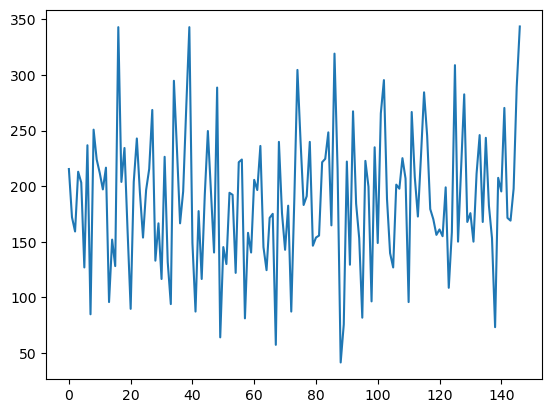

In [5]:
# 随机选择一个序列并可视化
import random
rd = random.randint(0, len(sequences)-1)
plt.plot(sequences[rd])

Min length: 62
Max length: 4894
Mean length: 481.08621372902996
Median length: 233.0
Standard deviation of length: 676.3161316230736


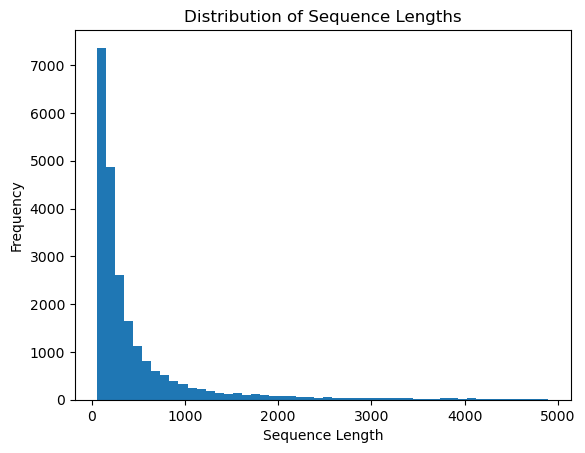

In [293]:
#查看序列长度的分布情况
lengths = [len(seq) for seq in sequences]
print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Mean length:", np.mean(lengths))
print("Median length:", np.median(lengths))
print("Standard deviation of length:", np.std(lengths))
#画出分布图

plt.hist(lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [294]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        # 初始化函数，接收sequences和labels作为参数
        self.sequences = [torch.tensor(seq, dtype=torch.float) for seq in sequences]
        # 将sequences中的每个元素转换为torch.tensor类型，并指定数据类型为long
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# 自定义填充函数
def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences, labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将序列长度截断到max_length
max_length = 1000
sequences = [seq[:max_length] for seq in sequences]
# 将序列填充到相同长度
max_len = max(len(seq) for seq in sequences)

# 使用numpy的pad函数对每个子序列进行填充
sequences = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant') for seq in sequences])
# 将数据集按照8:1:1划分为训练集，验证集和测试集
np.random.seed(0)
# 按8:1:1划分数据集
n_samples = len(sequences)
indices = np.random.permutation(n_samples)
train_idx = indices[:int(0.8*n_samples)]
val_idx = indices[int(0.8*n_samples):int(0.9*n_samples)]
test_idx = indices[int(0.9*n_samples):]
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []
for i in train_idx:
    x_train.append(sequences[i])
    y_train.append(labels[i])
for i in val_idx:
    x_val.append(sequences[i])
    y_val.append(labels[i])
for i in test_idx:
    x_test.append(sequences[i])
    y_test.append(labels[i])
    
train_dataset = SequenceDataset(x_train, y_train)
val_dataset = SequenceDataset(x_val, y_val)
test_dataset = SequenceDataset(x_test, y_test)



In [295]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_channels=1, base_channels=64):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # 输入: [B, 1, 5000]
            nn.Conv1d(input_channels, base_channels, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(base_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            # [B, 64, 1000]
            
            nn.Conv1d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(base_channels*2),
            nn.ReLU(),
            nn.Dropout(0.1),
            # [B, 128, 250]
            
            nn.Conv1d(base_channels*2, base_channels*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(base_channels*4),
            nn.ReLU(),
            nn.Dropout(0.1),
            # [B, 256, 125]
        )
        
    def forward(self, x):
        # x: [B, L] -> [B, 1, L]
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        return self.conv_layers(x)

class TransformerEncoder(nn.Module):
    def __init__(self, d_model=256, nhead=4, num_layers=2, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        # 位置编码
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
    def forward(self, x):
        # x: [B, C, L] -> [L, B, C]
        x = x.permute(2, 0, 1)
        x = self.pos_encoder(x)
        return self.transformer_encoder(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class SignalClassifier(nn.Module):
    def __init__(self, num_classes=5, d_model=256, nhead=4, num_layers=2, dim_feedforward=512):
        super().__init__()
        self.feature_extractor = CNNFeatureExtractor(input_channels=1, base_channels=64)
        self.transformer = TransformerEncoder(d_model=d_model, nhead=nhead, 
                                           num_layers=num_layers, dim_feedforward=dim_feedforward)
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model//2, num_classes)
        )
        
    def forward(self, x):
        # CNN特征提取
        features = self.feature_extractor(x)  # [B, C, L]
        # Transformer编码
        encoded = self.transformer(features)  # [L, B, C]
        # 取最后一个时间步的特征用于分类
        pooled = encoded[-1]  # [B, C]
        # 分类
        logits = self.classifier(pooled)
        return logits

In [296]:
lr = 5e-4
epochs = 20
warmup_steps = 100
total_steps = 1000
batch_size = 150
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SignalClassifier(
    num_classes=5,
    d_model=256,
    nhead=4,
    num_layers=2,
    dim_feedforward=512
).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
# 加载训练集和验证集
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# 训练循环
for epoch in range(epochs):
    # 训练模型
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs in tqdm(train_loader):
        signals = inputs[0]
        labels = inputs[1]
        optimizer.zero_grad()
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * signals.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += signals.size(0)
        train_correct += (predicted == labels).sum().item()
    train_loss /= train_total
    train_acc = train_correct / train_total
    # 验证模型
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs in tqdm(val_loader):
            signals = inputs[0]
            labels = inputs[1]
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * signals.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += signals.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= val_total
    val_acc = val_correct / val_total
    # 打印训练和验证结果
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


/home/zhangzezhou/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
  0%|          | 0/122 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 99.08it/s]


Epoch 1/20, Train Loss: 1.1066, Train Acc: 0.5258, Val Loss: 0.8099, Val Acc: 0.6460


100%|██████████| 16/16 [00:00<00:00, 98.42it/s]


Epoch 2/20, Train Loss: 0.8042, Train Acc: 0.6604, Val Loss: 0.8471, Val Acc: 0.6209


100%|██████████| 16/16 [00:00<00:00, 101.02it/s]


Epoch 3/20, Train Loss: 0.7177, Train Acc: 0.6993, Val Loss: 0.6374, Val Acc: 0.7349


100%|██████████| 16/16 [00:00<00:00, 101.37it/s]


Epoch 4/20, Train Loss: 0.6591, Train Acc: 0.7314, Val Loss: 0.6186, Val Acc: 0.7450


100%|██████████| 16/16 [00:00<00:00, 100.60it/s]


Epoch 5/20, Train Loss: 0.6171, Train Acc: 0.7480, Val Loss: 0.5676, Val Acc: 0.7693


100%|██████████| 16/16 [00:00<00:00, 99.43it/s]


Epoch 6/20, Train Loss: 0.5847, Train Acc: 0.7667, Val Loss: 0.5463, Val Acc: 0.7763


100%|██████████| 16/16 [00:00<00:00, 100.38it/s]


Epoch 7/20, Train Loss: 0.5581, Train Acc: 0.7773, Val Loss: 0.5261, Val Acc: 0.7970


100%|██████████| 16/16 [00:00<00:00, 99.96it/s]


Epoch 8/20, Train Loss: 0.5274, Train Acc: 0.7908, Val Loss: 0.5225, Val Acc: 0.7952


100%|██████████| 16/16 [00:00<00:00, 100.26it/s]


Epoch 9/20, Train Loss: 0.5123, Train Acc: 0.7975, Val Loss: 0.5321, Val Acc: 0.7891


100%|██████████| 16/16 [00:00<00:00, 98.62it/s]


Epoch 10/20, Train Loss: 0.5187, Train Acc: 0.7935, Val Loss: 0.5308, Val Acc: 0.7917


100%|██████████| 16/16 [00:00<00:00, 101.29it/s]


Epoch 11/20, Train Loss: 0.5222, Train Acc: 0.7945, Val Loss: 0.5365, Val Acc: 0.7882


100%|██████████| 16/16 [00:00<00:00, 97.13it/s]


Epoch 12/20, Train Loss: 0.5170, Train Acc: 0.7981, Val Loss: 0.5207, Val Acc: 0.7935


100%|██████████| 16/16 [00:00<00:00, 100.29it/s]


Epoch 13/20, Train Loss: 0.5167, Train Acc: 0.7955, Val Loss: 0.5329, Val Acc: 0.7886


100%|██████████| 16/16 [00:00<00:00, 99.11it/s]


Epoch 14/20, Train Loss: 0.5141, Train Acc: 0.7998, Val Loss: 0.5185, Val Acc: 0.7961


100%|██████████| 16/16 [00:00<00:00, 100.30it/s]


Epoch 15/20, Train Loss: 0.5215, Train Acc: 0.7934, Val Loss: 0.5609, Val Acc: 0.7794


100%|██████████| 16/16 [00:00<00:00, 100.57it/s]


Epoch 16/20, Train Loss: 0.5136, Train Acc: 0.7946, Val Loss: 0.5351, Val Acc: 0.7895


100%|██████████| 16/16 [00:00<00:00, 99.85it/s]


Epoch 17/20, Train Loss: 0.5226, Train Acc: 0.7928, Val Loss: 0.5264, Val Acc: 0.7926


100%|██████████| 16/16 [00:00<00:00, 99.72it/s]


Epoch 18/20, Train Loss: 0.5201, Train Acc: 0.7957, Val Loss: 0.5970, Val Acc: 0.7679


100%|██████████| 16/16 [00:00<00:00, 99.87it/s]


Epoch 19/20, Train Loss: 0.5124, Train Acc: 0.7975, Val Loss: 0.5251, Val Acc: 0.7952


100%|██████████| 16/16 [00:00<00:00, 100.67it/s]

Epoch 20/20, Train Loss: 0.5250, Train Acc: 0.7867, Val Loss: 0.5395, Val Acc: 0.7873


In [297]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#进行测试
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_labels = []
all_predicted = []
all_outputs = []
with torch.no_grad():
    for inputs in tqdm(test_loader):
        signals = inputs[0]
        labels = inputs[1]
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * signals.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_total += signals.size(0)
        test_correct += (predicted == labels).sum().item()

        # 收集所有真实标签和预测标签
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

test_loss /= test_total
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 98.83it/s]

Test Loss: 0.5097, Test Acc: 0.7958


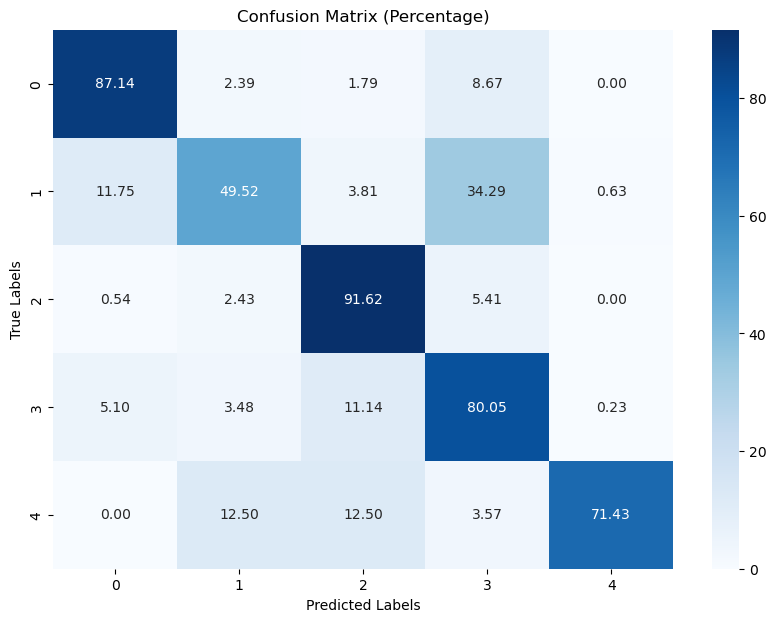

In [298]:
# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_predicted)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()

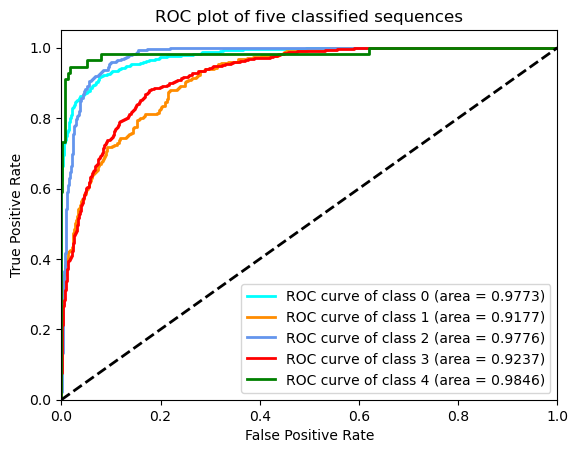

In [299]:
#使用测试集画出ROC曲线
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# 类别数量
num_classes = 5

# 将 all_outputs 转换为概率矩阵
all_predicted_proba = torch.nn.functional.softmax(torch.tensor(all_outputs), dim=1).numpy()
# 对标签进行 one - hot 编码
all_labels_one_hot = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])

# 计算每个类别的ROC曲线和ROC面积
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制所有类别的ROC曲线
plt.figure()
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#五条序列的分类roc图
plt.title('ROC plot of five classified sequences')
plt.legend(loc="lower right")
plt.show()